In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn.functional as F
from sklearn import decomposition
from sklearn import manifold
import time
import random

# Helpers

## General

In [ ]:
original_path = './resnet/cifar/resnet18_original_weights_cifar10'
improved_path = './resnet/cifar/resnet18_improved_weights_cifar10'
improved_path_img = './resnet/cifar/resnet18_improved.png'

In [ ]:
data_dir = '../CV_Data'
batch_size=128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def normalize_data(train_set,three_channels=False):
    print(train_set.data.shape)
    mean, std = train_set.data.mean(axis=(0,1,2))/255, train_set.data.std(axis=(0,1,2))/255
    print('Mean:', mean)
    print('Std: ', std)
    return transforms.Normalize(mean=tuple(mean),std=tuple(std))

In [ ]:
def save_model(model, path):
  torch.save(model.state_dict(), path)

In [ ]:
def load_model(model, path):
  model.load_state_dict(torch.load(path))

## Dataset

In [ ]:
def load_cifar(train_transforms, val_test_transforms):
    download = False
    if os.path.isdir(data_dir + '/' + 'cifar-10-batches-py') == False:
      download = True
    print(download)
    train_data = datasets.CIFAR10(root=data_dir, train=True, download=download, transform=train_transforms)
    test_data = datasets.CIFAR10(root=data_dir, train=False, download=download, transform=val_test_transforms)
    print("Training dataset:", train_data)
    print("Test dataset:", test_data)
    return train_data, test_data

In [ ]:
def get_classes(dataset):
    return dataset.classes

In [ ]:
def get_train_val_sets(train_data):
    train_set, val_set = torch.utils.data.random_split(train_data, [45000, 5000])
    return train_set, val_set

## Visualization

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

### Visualize images with classes

In [ ]:
def visualize_images_from_dataset(dataset):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = train_data[sample_idx]
        img = normalize_image(img)
        figure.add_subplot(rows, cols, i)
        plt.title(classes[label])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.show()

In [ ]:
def visualize_images_from_loader(loader):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3

    train_features, train_labels = next(iter(loader))

    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    for i in range(1,10):
      img = normalize_image(train_features[i].squeeze())
      label = classes[train_labels[i]]
      figure.add_subplot(rows, cols, i)
      plt.title(label)
      plt.axis("off")
      plt.imshow(img.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.show()

In [ ]:
def get_10_sample_of_the_same_class(class_name, dataset):
    sample = []
    while len(sample) < 10:
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        if classes[label] == class_name:
            sample.append((img,label))
    return sample

In [ ]:
def plot_sample_same_class(class_name, dataset):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    
    sample = get_10_sample_of_the_same_class(class_name, dataset)
    for i in range(1, cols * rows + 1):
        img, label = sample[i]
        img = normalize_image(img)
        figure.add_subplot(rows, cols, i)
        plt.title(classes[label])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.show()

### Metrics

In [ ]:
def plot_results(e, h, info, name):
    epochs_range = [i for i in range(e)]

    fig, (loss_plot, acc_plot) = plt.subplots(1, 2, figsize =(12,4))

    loss_plot.plot(epochs_range, h['train_loss'], color='red', label='train loss')
    loss_plot.plot(epochs_range, h['val_loss'], color='green', label='val loss')
    loss_plot.set_title('Epochs - Loss | {}'.format(info))
    loss_plot.legend()

    acc_plot.plot(epochs_range, h['train_acc'], color='red', label='train acc')
    acc_plot.plot(epochs_range, h['val_acc'], color='green', label='val acc')
    acc_plot.set_title('Epochs - Accuracy | {}'.format(info))
    acc_plot.legend()
    plt.savefig(name)
    plt.show()

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    conf_matrix = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(conf_matrix, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    return conf_matrix

In [ ]:
def get_accuracy_for_specific_labels(class_label,conf_matrix):
  position_in_dict = np.argmax(conf_matrix[class_label])
  return np.sum(conf_matrix.diagonal()[position_in_dict]/np.sum(conf_matrix[position_in_dict]))

In [ ]:
def show_per_class_accuracies():
    per_class_accuracies = []
    for idx,c in enumerate(classes):
        class_acc = get_accuracy_for_specific_labels(idx,cm)
        print(c + " class accuracy:", class_acc*100)
        per_class_accuracies.append((class_acc,idx))
    return per_class_accuracies

### Incorrect Examples

In [ ]:
def get_incorrect_examples(cm, per_class_accuracies):
    five_top_incorrect_classes = sorted(per_class_accuracies, key=lambda acc: acc[0])[:5]
    img_labels_preds_idx = []
    for acc,idx in five_top_incorrect_classes:
        for i in [item for item in np.where(labels == idx)[0] if item not in np.where(pred_labels == idx)[0]]:
            img_labels_preds_idx.append((images[i],test_data.targets[i],pred_labels[i], idx))
    return img_labels_preds_idx     

In [ ]:
def plot_incorrect_examples_from_top5_classes(n_images, confusion_matrix, per_class_accuracies, normalize=True):  
    fig = plt.figure(figsize = (16, 16))
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    incorrect_examples = get_incorrect_examples(confusion_matrix, per_class_accuracies)
    for i in range(rows*cols):
        sample_idx = random.randint(0, len(incorrect_examples))
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, false_label,idx = incorrect_examples[sample_idx]
        image = image.permute(1, 2, 0)
        true_class = classes[true_label]
        incorrect_class = classes[false_label]
        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy(),cmap="gray")
        ax.set_title(f'true label: {true_class} \n' \
                         f'pred label: {incorrect_class} ')
        ax.axis('off')

    fig.subplots_adjust(hspace = 0.4)

### PCA

In [ ]:
def get_representations(model, iterator):
    model.eval()
    outputs = []
    intermediates = []
    labels = []
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [ ]:
def get_pca(data):
    pca = decomposition.PCA()
    pca.n_components = 2
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
def plot_representations(data, labels, classes, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

## Training-Test Helpers

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)
        
        # compute output and loss
        output = model(data)
        loss = criterion(output, target)

        # backward and update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).cpu().sum()

        train_correct += correct
        train_loss += loss.data.item()

        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data.item()))
    
    # Get training epoch loss and accuracy
    train_loss /= len(train_loader.dataset)
    epoch_acc = float(train_correct) / len(train_loader.dataset)
    print('\nOn Training set Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)'.format(
      train_loss, train_correct, len(train_loader.dataset),
      100.0 * epoch_acc))
    return train_loss, epoch_acc

In [ ]:
def validate(val_loader, model, criterion):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
      for _, (data, target) in enumerate(val_loader):
          data = data.to(device)
          target = target.to(device)
          
          output = model(data)
          
          loss += criterion(output, target).data.item()

          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()
          
      loss /= len(val_loader.dataset)
      epoch_acc = float(correct) / len(val_loader.dataset)
      print('On Val set Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
          loss, correct, len(val_loader.dataset),
          100.0 * epoch_acc))
    return loss,epoch_acc

In [ ]:
def get_predictions(model, test_loader):
    model.eval()
    images = []
    labels = []
    probs = []
    correct = 0
    with torch.no_grad():
    
        for _, (data, target) in enumerate(test_loader):
          data = data.to(device)
          target = target.to(device)

          data = data.to(device)
          target = target.to(device)
          
          output = model(data)
          
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

          images.append(data.cpu())
          labels.append(target.cpu())
          probs.append(pred.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    acc = float(correct) / len(test_loader.dataset)
    print('\nOn Test set Accuracy: {}/{} ({:.3f}%)\n'.format(
      correct, len(test_loader.dataset),
      100.0 * acc))
    return images, labels, probs

In [ ]:
def fit_model(model, num_epochs, train_loader, val_loader, optimizer, criterion, lr_scheduler = None):

  best_acc = 0.0
  hist = { "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "per_epoch_time": [] }
  start_time = time.time()
  for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    if lr_scheduler != None:
      print("\nTrain Epoch {}: ".format(epoch))
      print("Current learning rate: {}".format(lr_scheduler.get_last_lr()))
    else:
      print("\nTrain Epoch {}: ".format(epoch))
      print("Learning rate: {}".format(optimizer.param_groups[0]['lr']))

    epoch_train_loss, epoch_train_acc = train(train_loader, model, criterion, optimizer, epoch)
    epoch_val_loss, epoch_val_acc = validate(val_loader, model, criterion)
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        print("New best Validation accuracy ({:.3f}%) achieved so far! \n".format(100.0 * best_acc))


    # Store acuracy and loss scores for current epoch
    hist['train_acc'].append(epoch_train_acc)
    hist['train_loss'].append(epoch_train_loss)
    hist['val_acc'].append(epoch_val_acc)
    hist['val_loss'].append(epoch_val_loss)

    if lr_scheduler != None:
      lr_scheduler.step()

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print("Epoch %d of %d with %.2f s" % (epoch, epochs, per_epoch_ptime))
    hist["per_epoch_time"].append(per_epoch_ptime)
    
  training_time = time.time() - start_time
  print('\nModel fit in : {:.2f}s'.format(training_time))
  

  return model, hist

# ResNet18




In [ ]:
resnet = torchvision.models.resnet18(pretrained=False)

In [ ]:
print(f'The model has {count_parameters(resnet):,} trainable parameters')

The model has 11,689,512 trainable parameters


# CIFAR10

Since CIFAR10 classes are 10 and not 1000 like Image Net, the last dense layer needs to output 10 features instead of 1000

In [ ]:
final_layer = nn.Linear(resnet.fc.in_features , 10)
resnet.fc = final_layer

In [ ]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
train_transforms = transforms.Compose(
    [
      transforms.Resize(64), # resize images to 64 x 64
      transforms.ToTensor()
    ])

val_test_transforms = transforms.Compose(
    [
     transforms.Resize(64),
     transforms.ToTensor()
    ])

In [ ]:
train_data, test_data = load_cifar(train_transforms, val_test_transforms)

False
Training dataset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./CV_Data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
           )
Test dataset: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./CV_Data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
           )


In [ ]:
transforms_normalize = normalize_data(train_data)
transforms_normalize

(50000, 32, 32, 3)
Mean: [0.49139968 0.48215841 0.44653091]
Std:  [0.24703223 0.24348513 0.26158784]


Normalize(mean=(0.49139967861519607, 0.48215840839460783, 0.44653091444546567), std=(0.24703223246328176, 0.24348512800005648, 0.26158784172796473))

In [ ]:
train_transforms.transforms.insert(2, transforms_normalize)

In [ ]:
val_test_transforms.transforms.insert(2, transforms_normalize)

In [ ]:
train_data, test_data = load_cifar(train_transforms, val_test_transforms)

False
Training dataset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./CV_Data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.49139967861519607, 0.48215840839460783, 0.44653091444546567), std=(0.24703223246328176, 0.24348512800005648, 0.26158784172796473))
           )
Test dataset: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./CV_Data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.49139967861519607, 0.48215840839460783, 0.44653091444546567), std=(0.24703223246328176, 0.24348512800005648, 0.26158784172796473))
           )


In [ ]:
classes = get_classes(test_data)
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Split into training 

In [ ]:
train_set, val_set = get_train_val_sets(train_data)

In [ ]:
import copy
val_set = copy.deepcopy(val_set)
val_set.dataset.transform = val_test_transforms

In [ ]:
val_test_transforms.transforms

[Resize(size=64, interpolation=bilinear),
 ToTensor(),
 Normalize(mean=(0.49139967861519607, 0.48215840839460783, 0.44653091444546567), std=(0.24703223246328176, 0.24348512800005648, 0.26158784172796473))]

In [ ]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

## Initial Visualization

In [ ]:
print(f'Number of training examples: {len(train_set)}')
print(f'Number of validation examples: {len(val_set)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


Feature batch shape: torch.Size([128, 3, 64, 64])
Labels batch shape: torch.Size([128])


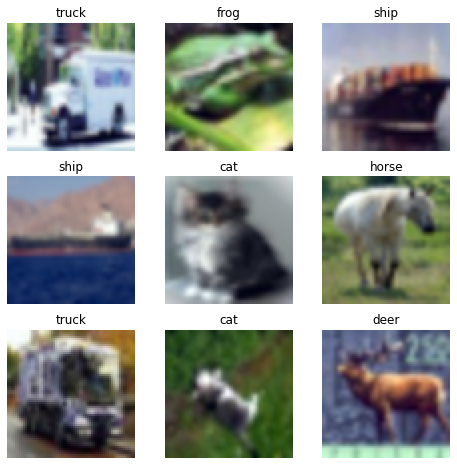

In [ ]:
visualize_images_from_loader(train_loader)

## Train the resnet18

In [ ]:
epochs = 50 
base_lr = 0.001

optimizer = torch.optim.SGD(resnet.parameters(), lr=base_lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
resnet, hist = fit_model(
    model = resnet, 
    num_epochs = epochs, 
    train_loader = train_loader, 
    val_loader = val_loader,
    optimizer = optimizer,
    criterion = loss_fn,
    lr_scheduler = None
  )


Train Epoch 1: 
Learning rate: 0.001
Train Epoch: 1 [12800/45000 (28%)]	Loss: 1.889182
Train Epoch: 1 [25600/45000 (57%)]	Loss: 1.628104
Train Epoch: 1 [38400/45000 (85%)]	Loss: 1.653385

On Training set Average loss: 0.0138, Accuracy: 16202/45000 (36.004%)
On Val set Average loss: 0.0121, Accuracy: 2290/5000 (45.800%)

New best Validation accuracy (45.800%) achieved so far! 

Epoch 1 of 50 with 37.60 s

Train Epoch 2: 
Learning rate: 0.001
Train Epoch: 2 [12800/45000 (28%)]	Loss: 1.418391
Train Epoch: 2 [25600/45000 (57%)]	Loss: 1.285695
Train Epoch: 2 [38400/45000 (85%)]	Loss: 1.271064

On Training set Average loss: 0.0105, Accuracy: 23020/45000 (51.156%)
On Val set Average loss: 0.0109, Accuracy: 2596/5000 (51.920%)

New best Validation accuracy (51.920%) achieved so far! 

Epoch 2 of 50 with 37.87 s

Train Epoch 3: 
Learning rate: 0.001
Train Epoch: 3 [12800/45000 (28%)]	Loss: 1.141971
Train Epoch: 3 [25600/45000 (57%)]	Loss: 1.139094
Train Epoch: 3 [38400/45000 (85%)]	Loss: 1.213

In [ ]:
save_model(resnet,original_path)

In [ ]:
# load_model(resnet, original_path)

In [ ]:
images, labels, pred_labels = get_predictions(resnet, test_loader)


On Test set Accuracy: 6553/10000 (65.530%)



# Visualization after training

## Loss and Accuracy Plots

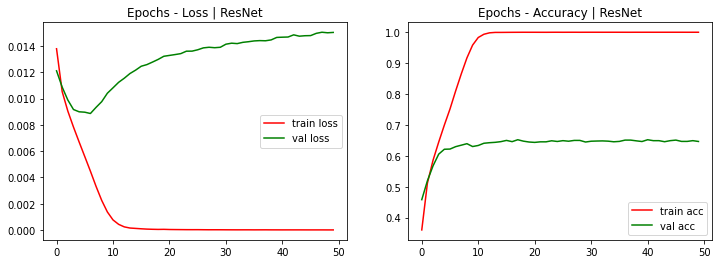

In [ ]:
plot_results(epochs, hist, info='ResNet', name='ResNet18_original.png')

In [ ]:
print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (
        np.mean(hist['per_epoch_time']), epochs, 1884.01))

Avg per epoch ptime: 37.68, total 50 epochs ptime: 1884.01


In [ ]:
per_class_accuracies = show_per_class_accuracies()

airplane class accuracy: 70.19999999999999
automobile class accuracy: 76.0
bird class accuracy: 50.0
cat class accuracy: 48.199999999999996
deer class accuracy: 56.10000000000001
dog class accuracy: 55.60000000000001
frog class accuracy: 76.5
horse class accuracy: 68.7
ship class accuracy: 81.2
truck class accuracy: 72.8


# Improvements

In [1]:
print('Uncomment the following lines to take a look at a grid of 6x6 images belonging to each class')
# for c in classes:
#     plot_sample_same_class(c, train_data) 

Uncomment the following lines to take a look at a grid of 6x6 images belonging to each class


## Pytorch Transformations

In [ ]:
train_transforms = transforms.Compose(
    [
      transforms.Resize(64),
      transforms.RandomHorizontalFlip(0.5), # Horizontal Flip THe data
      transforms.RandomRotation(10), 
      transforms.RandomAffine(degrees=0, shear=10, translate=(0.1,0.1), scale=(0.8,1.2)), #
      # transforms.RandomSolarize(threshold=0.1),
      # transforms.RandomAutocontrast(),
      transforms.ColorJitter(brightness=0.2,saturation=0.2, contrast=0.2),
      transforms.ToTensor(),
    transforms_normalize
    ])
val_test_transforms = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms_normalize
    ])

In [ ]:
train_data, test_data = load_cifar(train_transforms, val_test_transforms)

False
Training dataset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./CV_Data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.8, 1.2), shear=[-10.0, 10.0])
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
               ToTensor()
               Normalize(mean=(0.49139967861519607, 0.48215840839460783, 0.44653091444546567), std=(0.24703223246328176, 0.24348512800005648, 0.26158784172796473))
           )
Test dataset: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./CV_Data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor(

In [ ]:
train_set, val_set = get_train_val_sets(train_data)
val_set = copy.deepcopy(val_set)
val_set.dataset.transform = val_test_transforms

In [ ]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

## Visualization of the Data after Augmentation

Feature batch shape: torch.Size([128, 3, 64, 64])
Labels batch shape: torch.Size([128])


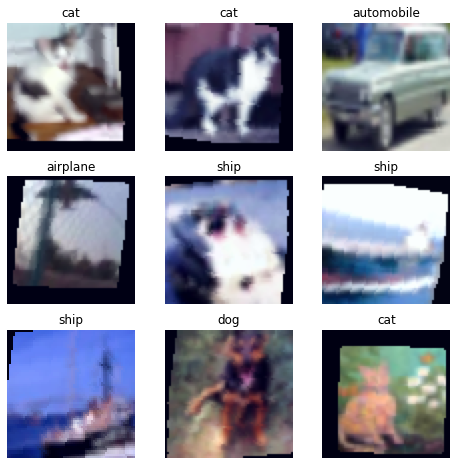

In [ ]:
visualize_images_from_loader(train_loader)

## Model's Architecture -- ResNet18_improved

In [ ]:
cfg = {
    'VGG_like': ['64unique', 64, 64, 'M']
}

class ResNetImproved(nn.Module):
    def __init__(self, model, cfg):
        super(ResNetImproved, self).__init__()
        self.features = self._vgg_like_conv(3, cfg['VGG_like']) 
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4
        self.avgpool = model.avgpool
        self.fc = self._create_classifer(model)
        self._initialize_weights()

        
    def _vgg_like_conv(self, in_channels, list_layers):
      layers = []
      for x in list_layers:
          if x == 'M':
            layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1)]
          else:
            if x == '64unique':
              x = int(x[0:2])
              layers += [nn.Conv2d(in_channels, x, stride=2, kernel_size=3, padding=3, bias=False),
                          nn.BatchNorm2d(x), # added batch normalizaiton layers
                        nn.ReLU(inplace=True)]


            else:
              layers += [nn.Conv2d(in_channels, x, kernel_size=(3,3), bias=False),
                        nn.BatchNorm2d(x), # added batch normalizaiton layers
                        nn.ReLU(inplace=True)]
          in_channels = x 
      return nn.Sequential(*layers)

    def _create_classifer(self, model):
        return nn.Sequential(
            nn.Dropout(0.1),
            model.fc
        )  

    def _initialize_weights(self) -> None:
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.features(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        
resnet_improved = ResNetImproved(torchvision.models.resnet18(pretrained=False, zero_init_residual=True, num_classes=10), cfg)
resnet_improved.to(device)

ResNetImproved(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 6

In [ ]:
print(f'The model has {count_parameters(resnet_improved):,} trainable parameters')

The model has 11,247,946 trainable parameters


## Train the model



In [ ]:
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, smoothing: float = 0.1, 
                 reduction="mean", weight=None):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing   = smoothing
        self.reduction = reduction
        self.weight    = weight

    def reduce_loss(self, loss):
        return loss.mean() if self.reduction == 'mean' else loss.sum() \
         if self.reduction == 'sum' else loss

    def linear_combination(self, x, y):
        return self.smoothing * x + (1 - self.smoothing) * y

    def forward(self, preds, target):
        assert 0 <= self.smoothing < 1

        if self.weight is not None:
            self.weight = self.weight.to(preds.device)

        n = preds.size(-1)
        log_preds = F.log_softmax(preds, dim=-1)
        loss = self.reduce_loss(-log_preds.sum(dim=-1))
        nll = F.nll_loss(
            log_preds, target, reduction=self.reduction, weight=self.weight
        )
        return self.linear_combination(loss / n, nll)

In [ ]:
epochs = 50   
base_lr = 0.01
learning_rate_decay = 0.1    
#  weight_decay=4e-5
optimizer = torch.optim.SGD(resnet_improved.parameters(), lr=base_lr, momentum=0.9, weight_decay=4e-5)
# loss_fn = nn.CrossEntropyLoss()
loss_fn = LabelSmoothingLoss(smoothing = 0.1, reduction="mean")

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,27,40,47], gamma=learning_rate_decay)

In [ ]:
resnet_improved, hist = fit_model(
    model = resnet_improved, 
    num_epochs = epochs, 
    train_loader = train_loader, 
    val_loader = val_loader,
    optimizer = optimizer,
    criterion = loss_fn,
    lr_scheduler = lr_scheduler
  )


Train Epoch 1: 
Current learning rate: [0.01]
Train Epoch: 1 [12800/45000 (28%)]	Loss: 1.819735
Train Epoch: 1 [25600/45000 (57%)]	Loss: 1.787675
Train Epoch: 1 [38400/45000 (85%)]	Loss: 1.634469

On Training set Average loss: 0.0144, Accuracy: 16681/45000 (37.069%)
On Val set Average loss: 0.0132, Accuracy: 2447/5000 (48.940%)

New best Validation accuracy (48.940%) achieved so far! 

Epoch 1 of 50 with 74.60 s

Train Epoch 2: 
Current learning rate: [0.01]
Train Epoch: 2 [12800/45000 (28%)]	Loss: 1.570226
Train Epoch: 2 [25600/45000 (57%)]	Loss: 1.528953
Train Epoch: 2 [38400/45000 (85%)]	Loss: 1.529117

On Training set Average loss: 0.0121, Accuracy: 23436/45000 (52.080%)
On Val set Average loss: 0.0109, Accuracy: 3055/5000 (61.100%)

New best Validation accuracy (61.100%) achieved so far! 

Epoch 2 of 50 with 74.47 s

Train Epoch 3: 
Current learning rate: [0.01]
Train Epoch: 3 [12800/45000 (28%)]	Loss: 1.327943
Train Epoch: 3 [25600/45000 (57%)]	Loss: 1.276296
Train Epoch: 3 [384

In [ ]:
# torch.save(vgg_new16.state_dict(), 'vgg_new16_cifar10.pth')
# save_model(vgg_new16,'vgg_new16_cifar10.pth')

In [ ]:
save_model(resnet_improved, improved_path)

In [ ]:
images, labels, pred_labels = get_predictions(resnet_improved, test_loader)


On Test set Accuracy: 8187/10000 (81.870%)



## Visualization after training

In [ ]:
classes = get_classes(test_data)

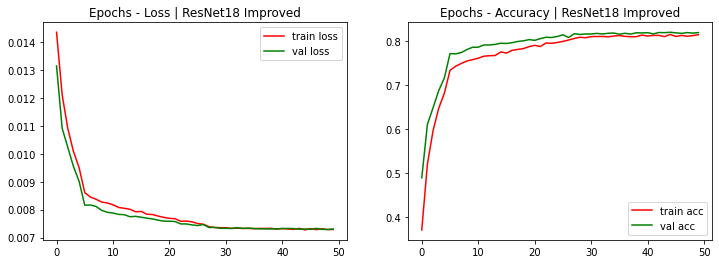

In [ ]:
plot_results(epochs, hist, info='ResNet18 Improved', name=improved_path_img)

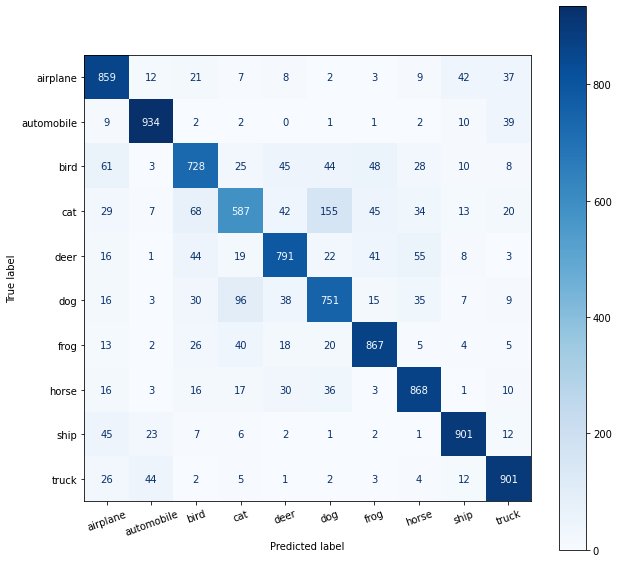

In [ ]:
cm = plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
per_class_accuracies = show_per_class_accuracies()

airplane class accuracy: 85.9
automobile class accuracy: 93.4
bird class accuracy: 72.8
cat class accuracy: 58.699999999999996
deer class accuracy: 79.10000000000001
dog class accuracy: 75.1
frog class accuracy: 86.7
horse class accuracy: 86.8
ship class accuracy: 90.10000000000001
truck class accuracy: 90.10000000000001


## Incorrect examples

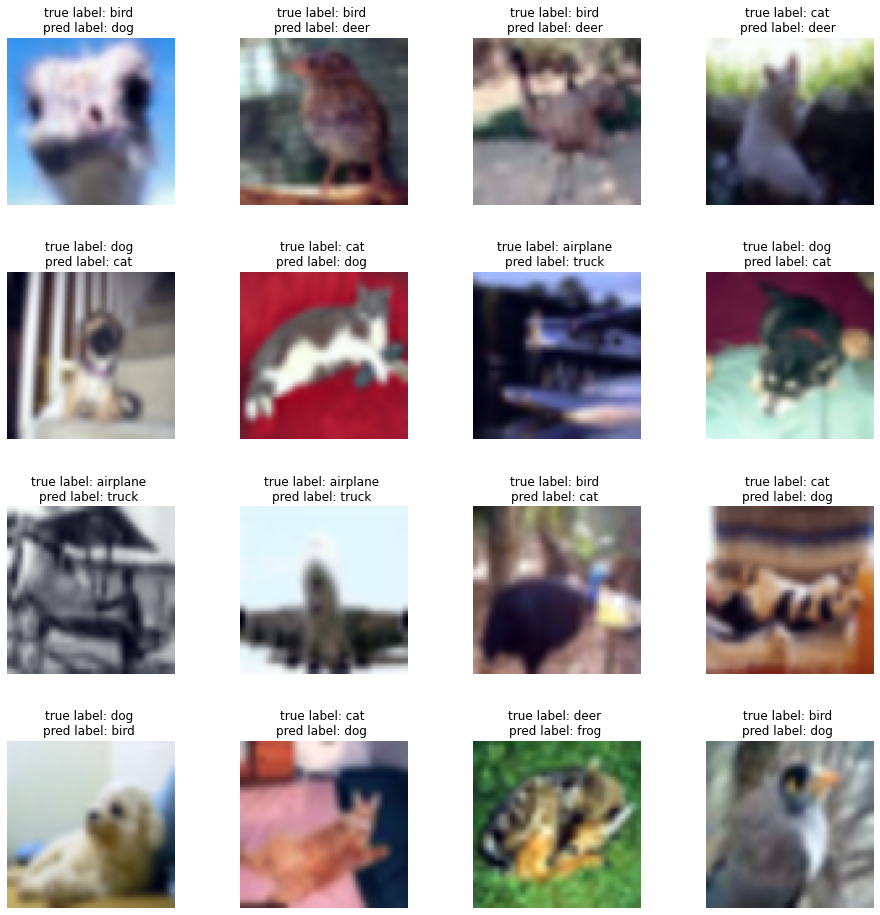

In [ ]:
plot_incorrect_examples_from_top5_classes(16,cm, per_class_accuracies)

### PCA

In [ ]:
outputs, labels = get_representations(resnet_improved, test_loader)

In [ ]:
outputs[:1]

tensor([[-0.6782,  0.1882, -0.7989,  3.0042, -1.2416,  1.7714,  0.1364, -1.3717,
         -0.1656, -0.4827]])

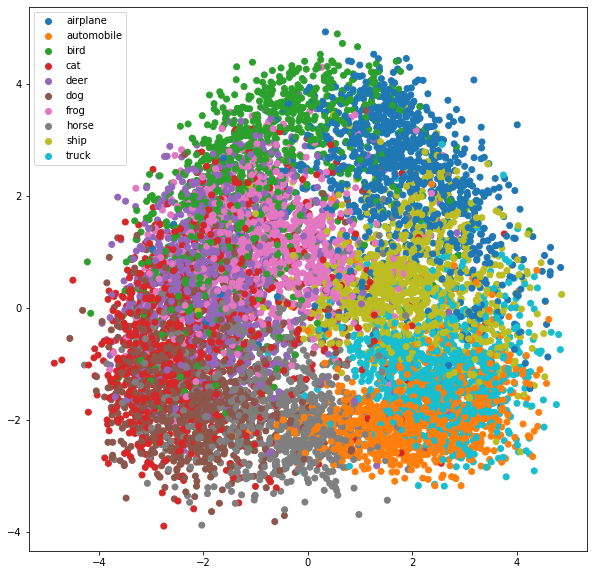

In [ ]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)